# load libaries

In [14]:
import os
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt 

import ogr2ogr


# convert from pbf to o5m (only once)

In [15]:
##convert from pbf to o5m with osmconvert
os.system('osmconvert germany-latest.osm.pbf -o=germany.o5m')

1

In [17]:
#set name
name_="Hohenzollern"

# filter highways only from entire germany OSM (only once)

In [32]:
#first filter all highways from osm germany
os.system('osmfilter germany.o5m --keep="highway=*" -o=highways_germany.osm')

In [33]:
os.system('osmconvert highways_germany.osm -o=highways_germany.o5m')

# filter specific streetname from OSM highways

In [34]:
#set name

In [35]:
# filter highways to given names with osmfilter
# takes about 1 minute
os.system('osmfilter highways_germany.o5m --keep="name=*'+name_+'* and highway=*" -o=streetnames_osm/highway_'+name_+'.osm')

0

# from OSM to shape/gpkg/geojson

In [36]:
# useful resouce: https://www.compose.com/articles/how-to-transform-and-use-openstreetmap-data-into-geojson-using-gdal/

#ogr2ogr -skipfailures -f "ESRI Shapefile" streets_shapefiles streets_liechtenstein.osm
#to shapefile
#ogr2ogr.main(["-skipfailures","-f", "ESRI Shapefile", "highway_"+name_, "highway_"+name_+".osm"])

#to gpkg
ogr2ogr.main(["-skipfailures","-f", "GPKG", "streetnames_gpkg/highway_"+name_+".gpkg","streetnames_osm/highway_"+name_+".osm"])

#to geojson (seems not to works so far)
#ogr2ogr.main(["-skipfailures","-f", "GeoJSON", "highway_"+name_+".geojson","-nln","lines","highway_"+name_+".osm"])
#ogr2ogr.main(["-skipfailures","-f", "GeoJSON", "highway_"+name_+".geojson","highway_"+name_+".osm",  "lines" ]) # "  "lines" , "points" ,"-nlt","LINESTRING


True

# Lade gefilterte Straßen

C:\Users\Simon\Anaconda3\envs\geo_julab3\lib\site-packages\geopandas\geodataframe.py:577: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


<AxesSubplot:>

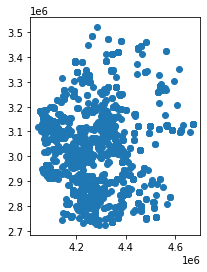

In [37]:
import shapely; 
shapely.speedups.disable() #due to some hicup in current geopandas version this step is neccesary

highway_name=gpd.read_file("streetnames_gpkg/highway_"+name_+".gpkg", layer='lines')
highway_name = highway_name.to_crs("EPSG:3035")
highway_name.centroid.plot()

In [38]:
highway_name.head()

,osm_id,name,highway,waterway,aerialway,barrier,man_made,z_order,other_tags,geometry
0,3615294,Heiligenlohstraße,residential,None,None,None,None,3,"""lit""=>""yes"",""oneway""=>""yes"",""surface""=>""aspha...","LINESTRING (4391649.989 2944767.516, 4391641.6..."
1,4268154,Heilige-Grab-Straße,residential,None,None,None,None,3,"""lanes""=>""3"",""lanes:backward""=>""2"",""lanes:forw...","LINESTRING (4668650.126 3128539.030, 4668660.8..."
2,4280922,Heiliggrabstraße,residential,None,None,None,None,3,"""lit""=>""yes"",""lanes""=>""2"",""surface""=>""asphalt""...","LINESTRING (4384989.361 2977105.180, 4384992.6..."
3,4396682,Heiligengeistwall,secondary,None,None,None,None,6,"""cycleway""=>""track"",""lanes""=>""3"",""lanes:backwa...","LINESTRING (4201137.667 3338467.144, 4201141.5..."
4,4426237,Heiligen-Geist-Kamp,primary,None,None,None,None,7,"""bicycle""=>""use_sidepath"",""cycleway""=>""right"",...","LINESTRING (4367615.554 3418697.244, 4367605.1..."


## Füge Straßenabschnitte zu einer Straße zusammen

In [39]:
highway_name_buff=highway_name.copy()
highway_name_buff.geometry=highway_name_buff.buffer(10)

highway_name_buff_gdf = gpd.GeoDataFrame({'geometry': highway_name_buff.unary_union, 'ken': 1}, crs=highway_name.crs)
highway_name_buff_gdf=highway_name_buff_gdf.reset_index()
#highway_name_buff_gdf.head(2)

gdf_merged=gpd.sjoin(highway_name,highway_name_buff_gdf)
#gdf_merged.head(2)

gdf_merged_diss = gdf_merged.dissolve(by=['name','index'])
gdf_merged_diss=gdf_merged_diss.reset_index()
#gdf_merged_diss.head(2)

In [40]:
#gdf_merged_diss.centroid.plot()

In [41]:
print("Anzahl Straßenabschnitte: " + str(len(highway_name)))
print("Anzahl Straßen:            " + str(len(gdf_merged_diss)))

Anzahl Straßenabschnitte: 1952
Anzahl Straßen:            754


## Zähle Häufigkeiten

In [42]:
count_table=gdf_merged_diss.groupby('name')['ken'].count().reset_index().sort_values('ken', ascending=False)
count_table=count_table.rename(columns={'name':'Straßenname', 'ken':'Häufigkeit'})

count_table.head()

,Straßenname,Häufigkeit
40,Am Heiligenhäuschen,24
247,Heiligenweg,22
134,Heiligenbergstraße,21
30,Am Heiligenberg,18
131,Heiligenberg,17


# load state borders (only once)

In [43]:
#import requests, zipfile, io

## downlaod and unzip Nuts Shape
#zip_file_url="https://daten.gdz.bkg.bund.de/produkte/vg/nuts2500/aktuell/nuts2500_01-01.utm32s.shape.zip"
#r = requests.get(zip_file_url)
#z = zipfile.ZipFile(io.BytesIO(r.content))
#z.extractall()

# load Nuts Shape
#bland=gpd.read_file(r"nuts2500_01-01.utm32s.shape/nuts2500/2500_NUTS1.shp")
#                     
#bland = bland.to_crs("EPSG:3035")
#bland.plot()

## Plotte

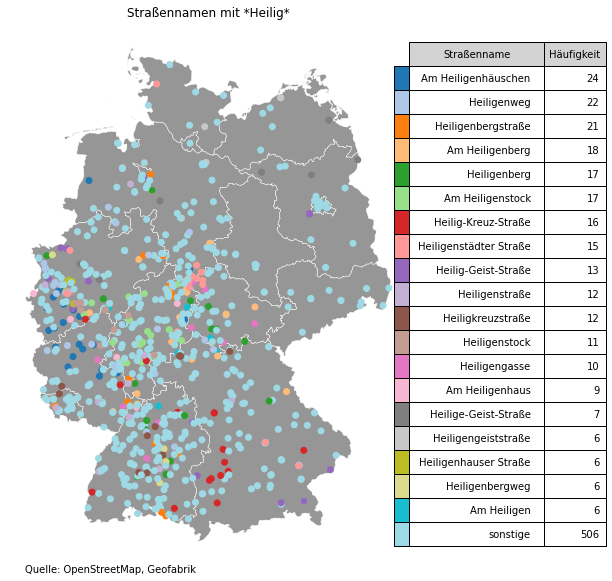

In [44]:

#create colormap based on count_table
#colors = plt.cm.BuPu_r(np.linspace(0, 0.5, len(count_table)))
colors = plt.cm.tab20(range(0,len(count_table)))



# add colormap to new col in count table
count_table['cols']=colors.tolist()

# get only centroid of each street
gdf_merged_diss_cent=gdf_merged_diss.copy()
gdf_merged_diss_cent.geometry=gdf_merged_diss.centroid
#gdf_merged_diss_cent

#merge color from countstable to centroids
gdf_merged_diss_cent_plot=pd.merge(gdf_merged_diss_cent, count_table, left_on='name', right_on='Straßenname')
#gdf_merged_diss_cent_plot

ax=bland.plot(color='#969696',figsize=(10,10), linewidths=0.5, edgecolors="white")

#plot_=gdf_merged_diss_cent_plot.plot(c=gdf_merged_diss_cent_plot['cols'], ax=ax)
plot_=gdf_merged_diss_cent_plot.plot(c=gdf_merged_diss_cent_plot['cols'], ax=ax)


plot_.set_title('Straßennamen mit *' + name_+'*')

#remove axis
plot_.set_axis_off()

if (len(count_table)>20):
    top=count_table[:19]
    sonstige_anzl=count_table[19:]['Häufigkeit'].sum()
    rowLabels_len=20
else:
    top=count_table#[:20]
    rowLabels_len= len(count_table)

cell_text = []
for row in range(len(top)):
    cell_text.append(top[['Straßenname','Häufigkeit']].iloc[row])
if (len(count_table)>20):
    cell_text.append(['sonstige',sonstige_anzl])

table_plt =plt.table(cellText=cell_text, 
          colLabels=top.columns,
          colColours=['lightgrey','lightgrey'],
          rowColours=colors,
          rowLabels=['    '] * rowLabels_len,
          loc='right')

table_plt.auto_set_column_width(col=list(range(len(count_table.columns)))) # Provide integer list of columns to adjust
table_plt.scale(0.8,2)



#Quelle
plot_.text(bland.total_bounds[0], bland.total_bounds[1]*0.98, "Quelle: OpenStreetMap, Geofabrik")

plt.savefig('streetnames_plots/plt_' + name_+'.png', bbox_inches='tight')